Auteur: Michaël Leroy

    Création  geodataframe des Noeuds du graph:
        attributs:
          * osmid : id openstreetmap de ref de la commune  <- index
          * codegeo: code insee pour pouvoir requeter sur les autres datasets
          * y: longitude point central de la commune
          * x: lattitude point centra de la commune	

          * counts: décompte du nombre de tags label 1 contenus dans le polygone de la commune
          * geometry: area shape de la commune

        ( A reprendre ou a requeter dans les datasets consolidés ?)
            pop:  nombre d'habitants
            bornes: 
            puissances:
            ....

  Les edges sont crées entre le centre commune et les 5 plus proches centres voisins (BallTree sklearn, distance Haversine), mais sans attributs à ce stade


  [TODO] vérifier si il ne faut pas mettre (v,u,1) quand (u,v,0)
          existe pour tenir compte de l'eventuelle non réciprocité des trajets routier
          en fonction des voies empruntées. En théorie pas nécessaire dataframe avec multi index,
          mais....


In [47]:
## For env version problem check

# import os
# os.environ['USE_PYGEOS'] = '0'
# import geopandas as gpd
# import osmnx as ox
# import networkx as nx
# import pyproj
# from shapely.ops import transform


In [48]:
class CFG:
    area = [
        'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté',
    'Brittany',
    'Centre-Val de Loire',
    'Grand Est',
    'Hauts-de-France',
    'Île-de-France',
    'Normandie',
    'Nouvelle-Aquitaine',
    'Occitanie',
    'Pays de la Loire',
    'Provence-Alpes-Côte d\'Azur'
]
    area_name = 'france'      #'_'.join(area)

    

    bornes = False

    viz = True

    roads = (
        '|motorway'
        '|motorway_link'
        '|trunk'
        '|trunk_link'
        '|primary'
        '|primary_link'
        '|secondary'
        '|secondary_link'
        '|tertiary'
         '|tertiary_link'
    )

        # '|primary'
        # '|motorway_link'
        
        # '|primary_link'

        # '|secondary'
        # '|secondary_link'
        
        
        #  '|tertiary'
        #  '|tertiary_link'

    data_path = './osm_datas/'

import joblib
joblib.dump(CFG.area, 'CFG.pkl')    

import os
os.environ['USE_PYGEOS'] = '0'

%load_ext autoreload
%autoreload


%aimport OSM_helper_functions
%aimport OCM_helper_functions

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
from OSM_helper_functions import *
from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 

Administratives = {
    'Auvergne-Rhône-Alpes': ['Ain', 'Allier', 'Ardèche', 'Cantal', 'Drôme', 'Isère', 'Loire', 'Haute-Loire', 'Puy-de-Dôme', 'Rhône', 'Savoie', 'Haute-Savoie'],
    'Bourgogne-Franche-Comté': ['Côte-d\'Or', 'Doubs', 'Jura', 'Nièvre', 'Haute-Saône', 'Saône-et-Loire', 'Yonne', 'Territoire de Belfort'],
    'Brittany': ['Côtes-d\'Armor', 'Finistère', 'Ille-et-Vilaine', 'Morbihan'],
    'Centre-Val de Loire': ['Cher', 'Eure-et-Loir', 'Indre', 'Indre-et-Loire', 'Loir-et-Cher', 'Loiret'],
    # 'Corse': ['Corse-du-Sud', 'Haute-Corse'],
    'Grand Est': ['Ardennes', 'Aube', 'Marne', 'Haute-Marne', 'Meurthe-et-Moselle', 'Meuse', 'Moselle', 'Bas-Rhin', 'Haut-Rhin', 'Vosges'],
    'Hauts-de-France': ['Aisne', 'Nord', 'Oise', 'Pas-de-Calais', 'Somme'],
    'Île-de-France': ['Paris', 'Seine-et-Marne', 'Yvelines', 'Essonne', 'Hauts-de-Seine', 'Seine-Saint-Denis', 'Val-de-Marne', 'Val-d\'Oise'],
    'Normandie': ['Calvados', 'Eure', 'Manche', 'Orne', 'Seine-Maritime'],
    'Nouvelle-Aquitaine': ['Charente', 'Charente-Maritime', 'Corrèze', 'Creuse', 'Dordogne', 'Gironde', 'Landes', 'Lot-et-Garonne', 'Pyrénées-Atlantiques', 'Deux-Sèvres', 'Vienne', 'Haute-Vienne'],
    'Occitanie': ['Ariège', 'Aude', 'Aveyron', 'Gard', 'Haute-Garonne', 'Gers', 'Hérault', 'Lot', 'Lozère', 'Hautes-Pyrénées', 'Pyrénées-Orientales', 'Tarn', 'Tarn-et-Garonne'],
    'Pays de la Loire': ['Loire-Atlantique', 'Maine-et-Loire', 'Mayenne', 'Sarthe', 'Vendée'],
    'Provence-Alpes-Côte d\'Azur': ['Alpes-de-Haute-Provence', 'Hautes-Alpes', 'Alpes-Maritimes', 'Bouches-du-Rhône', 'Var', 'Vaucluse']
}

Regions = [
    'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté',
    'Brittany',
    'Centre-Val de Loire',
    # 'Corse',
    'Grand Est',
    'Hauts-de-France',
    'Île-de-France',
    'Normandie',
    'Nouvelle-Aquitaine',
    'Occitanie',
    'Pays de la Loire',
    'Provence-Alpes-Côte d\'Azur'
]

Name2num = {
    'Ain': '01',
    'Aisne': '02',
    'Allier': '03',
    'Alpes-de-Haute-Provence': '04',
    'Hautes-Alpes': '05',
    'Alpes-Maritimes': '06',
    'Ardèche': '07',
    'Ardennes': '08',
    'Ariège': '09',
    'Aube': '10',
    'Aude': '11',
    'Aveyron': '12',
    'Bouches-du-Rhône': '13',
    'Calvados': '14',
    'Cantal': '15',
    'Charente': '16',
    'Charente-Maritime': '17',
    'Cher': '18',
    'Corrèze': '19',
    # 'Corse-du-Sud': '2A',
    # 'Haute-Corse': '2B',
    'Côte-d\'Or': '21',
    'Côtes-d\'Armor': '22',
    'Creuse': '23',
    'Dordogne': '24',
    'Doubs': '25',
    'Drôme': '26',
    'Eure': '27',
    'Eure-et-Loir': '28',
    'Finistère': '29',
    'Gard': '30',
    'Haute-Garonne': '31',
    'Gers': '32',
    'Gironde': '33',
    'Hérault': '34',
    'Ille-et-Vilaine': '35',
    'Indre': '36',
    'Indre-et-Loire': '37',
    'Isère': '38',
    'Jura': '39',
    'Landes': '40',
    'Loir-et-Cher': '41',
    'Loire': '42',
    'Haute-Loire': '43',
    'Loire-Atlantique': '44',
    'Loiret': '45',
    'Lot': '46',
    'Lot-et-Garonne': '47',
    'Lozère': '48',
    'Maine-et-Loire': '49',
    'Manche': '50',
    'Marne': '51',
    'Haute-Marne': '52',
    'Mayenne': '53',
    'Meurthe-et-Moselle': '54',
    'Meuse': '55',
    'Morbihan': '56',
    'Moselle': '57',
    'Nièvre': '58',
    'Nord': '59',
    'Oise': '60',
    'Orne': '61',
    'Pas-de-Calais': '62',
    'Puy-de-Dôme': '63',
    'Pyrénées-Atlantiques': '64',
    'Hautes-Pyrénées': '65',
    'Pyrénées-Orientales': '66',
    'Bas-Rhin': '67',
    'Haut-Rhin': '68',
    'Rhône': '69',
    'Haute-Saône': '70',
    'Saône-et-Loire': '71',
    'Sarthe': '72',
    'Savoie': '73',
    'Haute-Savoie': '74',
    'Paris': '75',
    'Seine-Maritime': '76',
    'Seine-et-Marne': '77',
    'Yvelines': '78',
    'Deux-Sèvres': '79',
    'Somme': '80',
    'Tarn': '81',
    'Tarn-et-Garonne': '82',
    'Var': '83',
    'Vaucluse': '84',
    'Vendée': '85',
    'Vienne': '86',
    'Haute-Vienne': '87',
    'Vosges': '88',
    'Yonne': '89',
    'Territoire de Belfort': '90',
    'Essonne': '91',
    'Hauts-de-Seine': '92',
    'Seine-Saint-Denis': '93',
    'Val-de-Marne': '94',
    'Val-d\'Oise': '95'
}


AREA = []
for area in CFG.area:
    AREA.extend(Administratives[area] )
# AREA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
data_path = './datas'
file_name = 'decoupage_administratif'


communes = gpd.read_feather(os.path.join(data_path,f'[{CFG.area_name}]{file_name}_osmid_centre.feather'))

communes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
metro = Name2num.values()
communes = communes.query("dep in @metro")

Dirty fix on errors in osmid from previous notebook

# TODO : enquire why, move fix to prevoius notebook

In [51]:
# MANUAL FIX FOR MISSING OSMID ON Nominatim resquests failures
communes.loc[5228 , ['osmid','x','y']] = (89493,45.34241,0.14665)
communes.loc[5229 , ['osmid','x','y']] = (63211,45.32810,-0.19941)
communes.loc[10916, ['osmid','x','y']] = (59355,44.000480,4.368443)
communes.loc[34954, ['osmid','x','y']] = (78755,48.21385,-0.21375)

In [52]:
dup = communes[communes[['osmid']].duplicated()]
dup

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,osmid,x,y
1039,02675,02,32,756530,6931643,Sainte-Croix,"POLYGON ((3.77080 49.48567, 3.76486 49.48064, ...",2953115.0,49.4809517,3.7781066
1073,02712,02,32,741504,6898258,Sergy,"POLYGON ((3.60190 49.18196, 3.60124 49.18692, ...",2955576.0,49.1828833,3.5710256
5553,17007,17,75,400068,6571413,Anais,"POLYGON ((-0.90061 46.18719, -0.90721 46.19125...",117882.0,46.1870947,-0.9078872
5588,17044,17,75,419598,6511251,Berneuil,"POLYGON ((-0.62773 45.62821, -0.62584 45.62795...",138512.0,45.6429064,-0.600994
5663,17122,17,75,433264,6506895,Coulonges,"POLYGON ((-0.43203 45.62467, -0.43911 45.62164...",152685.0,45.6092373,-0.4237379
5693,17154,17,75,408066,6528371,Les Essards,"POLYGON ((-0.75586 45.77929, -0.74841 45.77929...",125625.0,45.7917501,-0.7587287
5751,17215,17,75,428341,6491622,Lussac,"POLYGON ((-0.47459 45.45942, -0.47100 45.45878...",154481.0,45.469752,-0.476925
5763,17227,17,75,420035,6501542,Mazerolles,"POLYGON ((-0.61499 45.57141, -0.61348 45.56877...",152689.0,45.5481449,-0.581715
5765,17229,17,75,441679,6474613,Mérignac,"POLYGON ((-0.28163 45.33836, -0.29512 45.34106...",124631.0,45.3241667,-0.2943867
5774,17239,17,75,440267,6530043,Mons,"POLYGON ((-0.29918 45.80209, -0.30135 45.80614...",154522.0,45.8213116,-0.3471728


In [53]:
for n, idx in enumerate(dup.index):
    communes.loc[idx,'osmid'] = n + 10

In [54]:
dup = communes[communes[['osmid']].duplicated()]
dup

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,osmid,x,y


In [55]:
# # Test on a sample
# deps = ['56']  #+['51','52','08','10']
# communes = communes.query("dep in @deps")



In [56]:


display(communes.head(1))
display(communes.info())
communes.shape

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,osmid,x,y
0,01001,01,84,848241,6563021,L'Abergement-Clémenciat,"POLYGON ((4.90497 46.16079, 4.90280 46.15795, ...",142240.0,46.1502427,4.9202187


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 34466 entries, 0 to 34954
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   codgeo    34466 non-null  object  
 1   dep       34466 non-null  object  
 2   reg       34466 non-null  object  
 3   xcl2154   34466 non-null  int64   
 4   ycl2154   34466 non-null  int64   
 5   libgeo    34466 non-null  object  
 6   geometry  34466 non-null  geometry
 7   osmid     34466 non-null  float64 
 8   x         34466 non-null  object  
 9   y         34466 non-null  object  
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 3.9+ MB


None

(34466, 10)

In [57]:
communes[communes.x.isna()]

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,osmid,x,y


In [58]:
communes['osmid'] = communes['osmid'].astype(int)
communes['osmid'] = communes['osmid'].astype(str)

C:\Users\demo\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


In [59]:
candidate_labels = joblib.load( os.path.join(CFG.data_path,f'[{CFG.area_name}]candidate_labels.pkl'))
labels2legend = joblib.load( os.path.join(CFG.data_path,f'[{CFG.area_name}]labels2legend.pkl'))

file_name = 'datatourisme-place-20230529-tagged'

tourism = gpd.read_feather(os.path.join(CFG.data_path,file_name + '.feather'))


In [60]:
tourism.set_crs(crs=4326)

,Nom_du_POI,Categories_de_POI,Latitude,Longitude,Adresse_postale,Code_postal_et_commune,Covid19_mesures_specifiques,Covid19_est_en_activite,Covid19_periodes_d_ouvertures_confirmees,Createur_de_la_donnee,SIT_diffuseur,Date_de_mise_a_jour,Contacts_du_POI,Classements_du_POI,Description,URI_ID_du_POI,geometry,tag,Class
0,Domaine de Sentout,https://www.datatourisme.fr/ontology/core#Plac...,44.7816964,-0.4337698,43 route de la Lande,33360#Lignan-de-Bordeaux,Réservation obligatoire par e-mail.\nNombre de...,,,OT de l'Entre-deux-Mers,SIRTAQUI Nouvelle-Aquitaine,2023-05-25,Domaine de Sentout#+33 6 85 95 61 54<>+33 5 56...,Agriculture Biologique#Agriculture Biologique,Nicolas et Karina PONS sont la troisième génér...,https://data.datatourisme.fr/23/84ce1e9a-95d1-...,POINT (-0.43377 44.78170),TastingProvider,"monument, historic site, church, monastery, ca..."
1,Fromagerie Onetik,https://www.datatourisme.fr/ontology/core#Plac...,43.3327632,-1.3048326,RD 252,64240#Macaye,Port de masque obligatoire,,,Office de Tourisme Pays Basque,SIRTAQUI Nouvelle-Aquitaine,2023-05-06,Fromagerie Onetik#+33 5 59 70 27 27#m.tristant...,Agriculture raisonnée#Agriculture raisonnée,"A 5 minutes de la base de loisir du Baigura, n...",https://data.datatourisme.fr/23/8ab8562f-b841-...,POINT (-1.30483 43.33276),TastingProvider,"monument, historic site, church, monastery, ca..."
2,Ferme Arnabar,https://www.datatourisme.fr/ontology/core#Plac...,43.2330195,-1.2976431,Village des Artisans Route de Saint-Jean-Pied-...,64780#Ossès,Gel hydroalcoolique à disposition.,,,Office de Tourisme Pays Basque,SIRTAQUI Nouvelle-Aquitaine,2023-05-23,Ferme Arnabar#+33 5 59 37 62 93#magasin@arnaba...,Bienvenue à la ferme#Bienvenue à la ferme,"Tout près de Saint Jean Pied de Port, découvre...",https://data.datatourisme.fr/23/8c160821-49d5-...,POINT (-1.29764 43.23302),TastingProvider,"monument, historic site, church, monastery, ca..."
3,Poteries Goicoechea,https://www.datatourisme.fr/ontology/core#Plac...,43.2330195,-1.2976431,Village des Artisans Route de Saint-Jean-Pied-...,64780#Ossès,Pass sanitaire obligatoire. Sens de circulatio...,,,Office de Tourisme Pays Basque,SIRTAQUI Nouvelle-Aquitaine,2023-05-23,Poteries Goicoechea#+33 5 59 37 71 30#contact@...,"Entreprise du Patrimoine Vivant, EPV#Entrepris...","Au coeur du Pays basque, à dix minutes de Sain...",https://data.datatourisme.fr/23/cc981eda-589c-...,POINT (-1.29764 43.23302),Store,"business, healtcare, office, institution, offi..."
4,Ferme Loupret,https://www.datatourisme.fr/ontology/core#Plac...,43.7558196,-0.6828155,150 route du Moulin,40250#Toulouzette,- Gel hydro-alcoolique à l'entrée\n- masque ob...,,,OT Terres de Chalosse,SIRTAQUI Nouvelle-Aquitaine,2023-03-07,Ferme Loupret#+33 5 58 97 90 42<>+33 6 29 88 7...,Agriculture raisonnée#Agriculture raisonnée|Bi...,"Sur la ferme familiale d'Eric et Valérie, les ...",https://data.datatourisme.fr/23/96ad69e3-5cf0-...,POINT (-0.68282 43.75582),TastingProvider,"monument, historic site, church, monastery, ca..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338027,Monument aux Morts,https://www.datatourisme.fr/ontology/core#Cult...,50.431052,1.668757,,62180#Airon-Saint-Vaast,,,,Pas-de-Calais Tourisme,Pas-de-Calais Tourisme,2021-12-09,Monuments aux morts###,,,https://data.datatourisme.fr/14/09af3d78-b7b3-...,POINT (1.66876 50.43105),PointOfInterest,"monument, historic site, church, monastery, ca..."
338028,La forêt d'Eperlecques,https://www.datatourisme.fr/ontology/core#Plac...,50.805306,2.153443,,62910#Éperlecques,,,,Pas-de-Calais Tourisme,Pas-de-Calais Tourisme,2021-10-13,EDEN 62#+33 3 21 32 13 74##https://eden62.fr/f...,,,https://data.datatourisme.fr/14/d34ce664-c13a-...,POINT (2.15344 50.80531),NaturalHeritage,"monument, historic site, church, monastery, ca..."
338029,Musée Fragonard de l'École vétérinaire de Mais...,http://schema.org/Museum|https://www.datatouri...,48.809039,2.436047,,94700#Maisons-Alfort,,,,Comité Régional du Tourisme Paris Ile de

In [61]:
tourism.crs

# Create Node geodataframe

In [62]:
display(communes.head(1),tourism.head(1)) 

,codgeo,dep,reg,xcl2154,ycl2154,libgeo,geometry,osmid,x,y
0,01001,01,84,848241,6563021,L'Abergement-Clémenciat,"POLYGON ((4.90497 46.16079, 4.90280 46.15795, ...",142240,46.1502427,4.9202187


,Nom_du_POI,Categories_de_POI,Latitude,Longitude,Adresse_postale,Code_postal_et_commune,Covid19_mesures_specifiques,Covid19_est_en_activite,Covid19_periodes_d_ouvertures_confirmees,Createur_de_la_donnee,SIT_diffuseur,Date_de_mise_a_jour,Contacts_du_POI,Classements_du_POI,Description,URI_ID_du_POI,geometry,tag,Class
0,Domaine de Sentout,https://www.datatourisme.fr/ontology/core#Plac...,44.7816964,-0.4337698,43 route de la Lande,33360#Lignan-de-Bordeaux,Réservation obligatoire par e-mail.\nNombre de...,,,OT de l'Entre-deux-Mers,SIRTAQUI Nouvelle-Aquitaine,2023-05-25,Domaine de Sentout#+33 6 85 95 61 54<>+33 5 56...,Agriculture Biologique#Agriculture Biologique,Nicolas et Karina PONS sont la troisième génér...,https://data.datatourisme.fr/23/84ce1e9a-95d1-...,POINT (-0.43377 44.78170),TastingProvider,"monument, historic site, church, monastery, ca..."


In [63]:
tourism['label'] = tourism.Class.map(labels2legend) 

tourism = tourism[['label','geometry']]


In [64]:
communes = communes[['osmid','x','y','codgeo','dep','reg','geometry']]

correct osmid = -2147483648

In [66]:
weird_osmids = communes[communes.osmid == '-2147483648'].index
display(communes.loc[weird_osmids])
for n, idx in enumerate (weird_osmids):
    communes.loc[idx,'osmid'] = str(-int(communes.loc[idx, 'osmid'] )- (n + 100) )
display(communes.loc[weird_osmids])

,osmid,x,y,codgeo,dep,reg,geometry
1646,-2147483648,43.8258394,6.1298863,04172,04,93,"POLYGON ((6.14226 43.78449, 6.15661 43.78732, ..."
5809,-2147483648,45.7058217,-0.4474511,17276,17,75,"POLYGON ((-0.29059 45.32664, -0.29069 45.32580..."
6751,-2147483648,47.2447849,4.8809293,21178,21,27,"POLYGON ((4.91591 47.25085, 4.91034 47.25279, ..."
9781,-2147483648,49.1093602,1.4269352,27554,27,28,"POLYGON ((1.38065 49.08067, 1.38858 49.08620, ..."
11936,-2147483648,43.9793542,0.4739444,32100,32,76,"POLYGON ((0.15572 43.87439, 0.15694 43.87078, ..."
17006,-2147483648,44.6973462,1.8552987,46292,46,76,"POLYGON ((1.82035 44.68227, 1.82045 44.68362, ..."
32437,-2147483648,44.1842023,5.1664171,84015,84,93,"POLYGON ((5.24267 44.20141, 5.23974 44.19780, ..."


,osmid,x,y,codgeo,dep,reg,geometry
1646,2147483548,43.8258394,6.1298863,04172,04,93,"POLYGON ((6.14226 43.78449, 6.15661 43.78732, ..."
5809,2147483547,45.7058217,-0.4474511,17276,17,75,"POLYGON ((-0.29059 45.32664, -0.29069 45.32580..."
6751,2147483546,47.2447849,4.8809293,21178,21,27,"POLYGON ((4.91591 47.25085, 4.91034 47.25279, ..."
9781,2147483545,49.1093602,1.4269352,27554,27,28,"POLYGON ((1.38065 49.08067, 1.38858 49.08620, ..."
11936,2147483544,43.9793542,0.4739444,32100,32,76,"POLYGON ((0.15572 43.87439, 0.15694 43.87078, ..."
17006,2147483543,44.6973462,1.8552987,46292,46,76,"POLYGON ((1.82035 44.68227, 1.82045 44.68362, ..."
32437,2147483542,44.1842023,5.1664171,84015,84,93,"POLYGON ((5.24267 44.20141, 5.23974 44.19780, ..."


In [67]:
# joblib.load( os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes.pkl')).head(1)

In [68]:
labels2legend.values()

dict_values(['activity', 'visit', 'fooding', 'sleeping', 'vehicule', 'working', 'EV Infra'])

In [69]:
tourism.set_geometry('geometry')

,label,geometry
0,visit,POINT (-0.43377 44.78170)
1,visit,POINT (-1.30483 43.33276)
2,visit,POINT (-1.29764 43.23302)
3,working,POINT (-1.29764 43.23302)
4,visit,POINT (-0.68282 43.75582)
...,...,...
338027,visit,POINT (1.66876 50.43105)
338028,visit,POINT (2.15344 50.80531)
338029,visit,POINT (2.43605 48.80904)
338030,visit,POINT (-2.03154 47.28741)


In [70]:
def get_tag_counts(geom):
    sub = tourism[tourism['geometry'].within(geom)]
    counts = sub.label.value_counts()
    return counts


counts = get_tag_counts(communes.iloc[20]['geometry'])
counts 

visit      3
working    1
Name: label, dtype: int64

In [71]:
for key , value in zip(counts.index, counts):
    display({key:value})

{'visit': 3}

{'working': 1}

In [72]:
communes = communes.sample(frac=1.0)

In [73]:
from shapely import Point
from networkx import MultiDiGraph
G = MultiDiGraph(crs = 4326)

total = communes.shape[0]
for n, (i, row) in enumerate(communes.iterrows()):
    counts = get_tag_counts(row['geometry'])
    # display(counts)
    print(f'{n+1}/{total} ~ {(n + 1) / total:.2%} ', end=' '*50 + '\r')
    attr = {
        'y': float(row.x),
        'x': float(row.y),
        # 'geometry': Point(float(row.x),float(row.y)),
        'codgeo': row.codgeo, 
        'area': row['geometry']
    }
    for key , value in zip(counts.index, counts):
        attr.update({key:int(value)})

    G.add_node(
        row.osmid,
        **attr
    )
    # if n == 1000 :
        # break




<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 34466 entries, 2531584 to 2741108
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   y         34466 non-null  float64 
 1   x         34466 non-null  float64 
 2   codgeo    34466 non-null  object  
 3   area      34466 non-null  object  
 4   sleeping  15412 non-null  float64 
 5   visit     17923 non-null  float64 
 6   fooding   6616 non-null   float64 
 7   working   6950 non-null   float64 
 8   vehicule  4166 non-null   float64 
 9   geometry  34466 non-null  geometry
dtypes: float64(7), geometry(1), object(2)
memory usage: 3.9+ MB


None

,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry
osmid,,,,,,,,,,
2531584,43.461438,-0.819766,64312,POLYGON ((-0.832953105776137 43.44755970632465...,2.0,NaN,NaN,NaN,NaN,POINT (-0.81977 43.46144)
279376,47.730421,0.777490,41255,POLYGON ((0.7426134063245691 47.72901158483156...,NaN,1.0,NaN,NaN,NaN,POINT (0.77749 47.73042)
1022241,47.129554,6.693006,25421,POLYGON ((6.710196593401414 47.130558839705444...,1.0,NaN,1.0,NaN,NaN,POINT (6.69301 47.12955)
153920,49.703376,4.943341,08409,"POLYGON ((4.968185038340734 49.70249532252551,...",20.0,20.0,19.0,3.0,NaN,POINT (4.94334 49.70338)
111919,44.922000,3.257620,48046,POLYGON ((3.2485359975552894 44.93934468866044...,NaN,2.0,NaN,NaN,NaN,POINT (3.25762 44.92200)


,y,x,codgeo,area,sleeping,visit,fooding,working,vehicule,geometry
osmid,,,,,,,,,,
71694,45.213600,4.906740,26133,POLYGON ((4.8905295562794775 45.21374554381834...,NaN,NaN,NaN,1.0,NaN,POINT (4.90674 45.21360)
5827802,48.722684,7.610694,67539,POLYGON ((7.6367784085187305 48.69910651139777...,13.0,3.0,NaN,1.0,NaN,POINT (7.61069 48.72268)
2573037,44.301186,4.566575,07268,"POLYGON ((4.599062017898887 44.30399175813055,...",2.0,28.0,NaN,1.0,NaN,POINT (4.56658 44.30119)
120229,45.873591,2.327008,23218,POLYGON ((2.3450715495157475 45.84793930622036...,NaN,NaN,NaN,NaN,NaN,POINT (2.32701 45.87359)
2741108,48.865960,3.507090,51359,"POLYGON ((3.486880769957156 48.85733296085165,...",NaN,NaN,NaN,NaN,NaN,POINT (3.50709 48.86596)


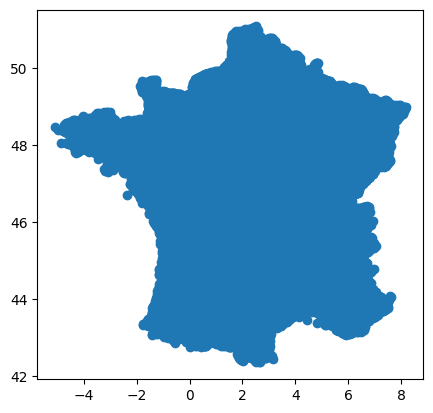

In [74]:
# Check
nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

joblib.dump(nodes,os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))
display(nodes.info(),nodes.head(5),nodes.tail(5))
nodes.plot()
del nodes

In [75]:
ox.save_graphml(
    G,
    os.path.join(CFG.data_path, f'[{CFG.area_name}]communes_temp_graph_with_only_nodes.graphml')
)